# <font size="7"> **Assignment-6**</font>
I hope this assignment will give you clarity on how mathematical models like **Multilayer Perceptrons (MLP)** can be made from scratch using **PyTorch** & can be used to solve complex, non-linear geometric problems **without relying on black-box libraries**.

---
# ⚫ **Mission Critical: The Exclusion Zone Protocol**

**Date:** Year 2142  
**Location:** Exoplanet *Kepler-186f*   **Clearance:** IITians

---

### **⚫ The Story**
Humanity has colonized the distant exoplanet *Kepler-186f*. While the surface is habitable, the planet's magnetic core is unstable. The **Global Defense Council (GDC)** has identified a dangerous phenomenon known as the **"Radiation Ring."**

Sensors indicate that the safe zones on the planet follow a peculiar geometry:
* ⚫ **The Core Zone:** Distance $< 2$ km from the colony center (Safe).
* ⚫ **The Outer Wilds:** Distance $> 4$ km from the colony center (Safe).
* ⚫ **The Dead Zone:** The region **between 2 km and 4 km** is flooded with lethal gamma radiation.

Your engineering team has deployed **3,000 sensor drones** across the colony to map this danger. Each drone reports its coordinates $(x, y)$ and a binary label:
* `1`: Radiation Detected (Dead Zone)
* `0`: Safe Zone

 **⚫ The Problem:** The sensors are cheap and prone to interference. Approximately **5%** of the drones are malfunctioning and reporting the wrong safety status (noise). The GDC mainframe is a legacy system that forbids the use of modern "Neural Libraries" (i.e., you cannot use `torch.nn` or `torch.optim`). You must build a **Multi-Layer Perceptron (MLP) from scratch** to filter out the noise and mathematically define the Exclusion Zone boundaries using **PyTorch**. ( Hint: You know this is a binary classification problem, which Loss function would you use?? )

---

### **⚫ Your Objective**

1.  **Initialize the System:** Use your **Group Number** as the random seed. This ensures your team works on a unique sensor distribution pattern.
2.  **Architect the Filter:** Construct a neural network with **3 hidden layers** (16 neurons each) to learn the non-linear "donut" shape of the Dead Zone.
3.  **Manual Calibration:** You cannot use auto-optimizers. You must manually calculate the gradients (Backpropagation) and update the system weights using **Gradient Descent**.
4.  **Verify Integrity:** Split your sensor data (70% training, 30% validation). Prove that your system doesn't just memorize the malfunctioning sensors (overfitting) but actually learns the geometric shape of the Dead Zone.

---

## ⚫ Engineering Constraints (Read Carefully)

**1. Restricted Modules**
*  **Forbidden:** You are strictly forbidden from importing `torch.nn` (Layers/Loss) or `torch.optim` (Optimizers).
*  **Allowed:** `import torch`, `import matplotlib.pyplot`, `import pandas`, `import numpy`, using `sklearn`.


**2. The Mechanics**
* **Forward Pass:** Must be implemented using raw matrix multiplication (`torch.matmul`) and bias addition.
* **Backward Pass:** You **MAY** use `loss.backward()` to compute gradients automatically (Autograd).
* **Optimization:** You **MUST** implement the weight updates manually (Stochastic Gradient Descent).
    > `w_new = w_old - learning_rate * w_old.grad`

**3. Loss Function**
Since `torch.nn` is banned, you must implement **Binary Cross Entropy** manually using basic tensor math.

$$Loss = -\frac{1}{N} \sum_{i=1}^{N} [y_i \cdot \log(\hat{y}_i) + (1-y_i) \cdot \log(1-\hat{y}_i)]$$

* **Note:** Ensure you handle the log of zero (numerical stability) or use `torch.clamp` to avoid `NaN` errors.

**4. Visual Proof:** Your final output must include a Decision Boundary Map showing the "Donut" shape.


---

### ⚫ **The GDC Dashboard (Required Output)**



The Global Defense Council requires visual confirmation that your system is stable before we can upload it to the drone fleet. You must generate a **3-Panel Heads-Up Display (HUD)** containing the following telemetry:

**1. System Error Trajectory (Loss Plot)**
* **Mission:** Plot the **Training Loss** (Blue) vs. **Validation Loss** (Orange) over all epochs.
* **Why:** We need to confirm that the system is actually learning and not just diverging (exploding gradients).

**2. Integrity Check (Accuracy Plot)**
* **Mission:** Plot the **Training Accuracy** vs. **Validation Accuracy**.
* **Why:** If Training Accuracy is high (95%) but Validation Accuracy is low (80%), you have failed to generalize. This is a sign of **Overfitting**—memorizing sensor noise instead of the Radiation Ring.

**3. Geospatial Threat Map (Decision Boundary)**
* **Mission:** Visualize the **Validation Set** on a 2D map.
* **Overlay:** Draw the neural network's **Decision Boundary** (the contours where confidence = 0.5).
* **Why:** The Commander needs to *see* the "Donut" shape. If your boundary looks like a jagged mess, the model is rejected.

---

In [ ]:
import torch
import numpy as np
# ===========================================================
# PART 1: Data Generation (The Exclusion Zone)
# ===========================================================

# ⚠️ INSTRUCTION: Replace 1 with your actual Group Number
GROUP_NUMBER = 1

# Set seed for reproducibility
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

def generate_data(n_samples=3000):
    """
    Generates 3000 sensor readings for the Kepler-186f Exclusion Zone.
    Shape: Concentric circles (Donut).
    Logic:
      - Dead Zone (1): 2km < distance < 4km
      - Safe Zone (0): distance < 2km OR distance > 4km
    """
    # Generate random coordinates between -5 and 5 km
    X = (torch.rand(n_samples, 2) * 10) - 5

    # Calculate distance from center (radius)
    radius = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)

    # Assign Labels: 1 if inside the Dead Zone, 0 otherwise
    y = ((radius > 2) & (radius < 4)).float().view(-1, 1)

    # Add 5% Noise (Malfunctioning Drones)
    n_noise = int(0.05 * n_samples)
    noise_indices = torch.randperm(n_samples)[:n_noise]
    y[noise_indices] = 1 - y[noise_indices] # Flip labels

    return X, y

# Generate the dataset
X_full, y_full = generate_data(3000)

print(f"Data Generated: {X_full.shape} samples.")
print(f"Target Generated: {y_full.shape} labels.")

Data Generated: torch.Size([3000, 2]) samples.
Target Generated: torch.Size([3000, 1]) labels.


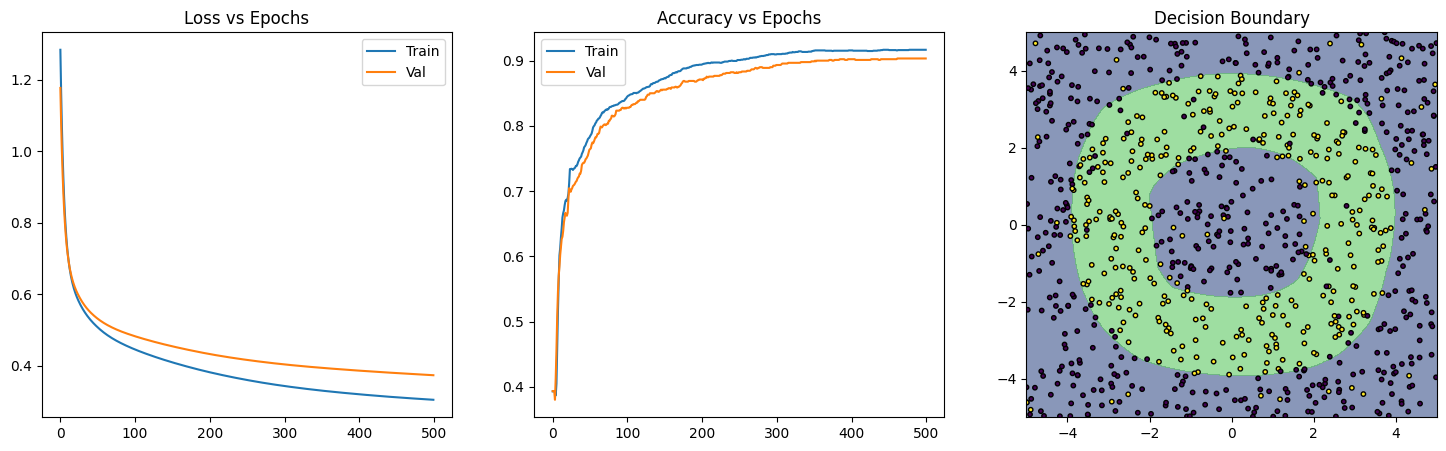

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Reproducibility


GROUP_NUMBER = 11
torch.manual_seed(GROUP_NUMBER)
np.random.seed(GROUP_NUMBER)

# Data Generation
def generate_data(n_samples=3000):
    X = (torch.rand(n_samples, 2) * 10) - 5
    r = torch.sqrt(X[:, 0]**2 + X[:, 1]**2)
    y = ((r > 2) & (r < 4)).float().view(-1, 1)

    n_noise = int(0.05 * n_samples)
    noise_idx = torch.randperm(n_samples)[:n_noise]
    y[noise_idx] = 1 - y[noise_idx]

    return X, y

X_raw, y_all = generate_data()

# Feature Engineering

x1, x2 = X_raw[:, 0:1], X_raw[:, 1:2]
radius = torch.sqrt(x1**2 + x2**2)

X_all = torch.cat([
    x1, x2,
    radius,
    radius**2,
    radius**3,
    x1**2,
    x2**2,
    x1**3,
    x2**3
], dim=1)

# Train / Validation Split
perm = torch.randperm(X_all.size(0))
split = int(0.7 * X_all.size(0))

train_idx, val_idx = perm[:split], perm[split:]

X_train, y_train = X_all[train_idx], y_all[train_idx]
X_val, y_val = X_all[val_idx], y_all[val_idx]

# Normalization
mu = X_train.mean(0, keepdim=True)
sigma = X_train.std(0, keepdim=True) + 1e-8

X_train = (X_train - mu) / sigma
X_val = (X_val - mu) / sigma

# Model Parameters
D_IN, D_H, D_OUT = X_train.shape[1], 16, 1

def init_param(shape, scale):
    p = torch.randn(*shape) * scale
    p.requires_grad_()
    return p

W1 = init_param((D_IN, D_H), np.sqrt(2 / D_IN))
W2 = init_param((D_H, D_H), np.sqrt(2 / D_H))
W3 = init_param((D_H, D_H), np.sqrt(2 / D_H))
W4 = init_param((D_H, D_OUT), np.sqrt(2 / D_H))

b1 = torch.full((1, D_H), 0.01, requires_grad=True)
b2 = torch.full((1, D_H), 0.01, requires_grad=True)
b3 = torch.full((1, D_H), 0.01, requires_grad=True)
b4 = torch.zeros((1, D_OUT), requires_grad=True)

PARAMS = [W1, b1, W2, b2, W3, b3, W4, b4]

# Activations & Forward Pass
def relu(z):
    return torch.clamp(z, min=0)

def sigmoid(z):
    return 1 / (1 + torch.exp(-z))

def forward(X):
    h1 = relu(X @ W1 + b1)
    h2 = relu(h1 @ W2 + b2)
    h3 = relu(h2 @ W3 + b3)
    return sigmoid(h3 @ W4 + b4)

# Loss & Metrics
def binary_cross_entropy(y_hat, y):
    eps = 1e-7
    y_hat = torch.clamp(y_hat, eps, 1 - eps)
    return -(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat)).mean()

def accuracy(y_hat, y):
    return ((y_hat >= 0.5).float() == y).float().mean()

# Training Utilities
def step(X, y, lr):
    y_hat = forward(X)
    loss = binary_cross_entropy(y_hat, y)
    acc = accuracy(y_hat, y)

    loss.backward()

    with torch.no_grad():
        for p in PARAMS:
            p -= lr * p.grad
            p.grad.zero_()

    return loss.item(), acc.item()

def evaluate(X, y):
    with torch.no_grad():
        y_hat = forward(X)
        return (
            binary_cross_entropy(y_hat, y).item(),
            accuracy(y_hat, y).item()
        )

# Training Loop
EPOCHS = 500
LR = 0.02

train_loss, val_loss = [], []
train_acc, val_acc = [], []

for _ in range(EPOCHS):
    l, a = step(X_train, y_train, LR)
    vl, va = evaluate(X_val, y_val)

    train_loss.append(l)
    train_acc.append(a)
    val_loss.append(vl)
    val_acc.append(va)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Loss
axes[0].plot(train_loss, label="Train")
axes[0].plot(val_loss, label="Val")
axes[0].set_title("Loss vs Epochs")
axes[0].legend()

# Accuracy
axes[1].plot(train_acc, label="Train")
axes[1].plot(val_acc, label="Val")
axes[1].set_title("Accuracy vs Epochs")
axes[1].legend()

# Decision Boundary
grid = np.linspace(-5, 5, 300)
xx, yy = np.meshgrid(grid, grid)

gx = torch.tensor(xx.reshape(-1, 1), dtype=torch.float32)
gy = torch.tensor(yy.reshape(-1, 1), dtype=torch.float32)
gr = torch.sqrt(gx**2 + gy**2)

X_grid = torch.cat([
    gx, gy,
    gr,
    gr**2,
    gr**3,
    gx**2,
    gy**2,
    gx**3,
    gy**3
], dim=1)

X_grid = (X_grid - mu) / sigma

with torch.no_grad():
    Z = forward(X_grid).reshape(xx.shape)

axes[2].contourf(xx, yy, Z, levels=[0, 0.5, 1], alpha=0.6)
axes[2].scatter(
    X_raw[val_idx, 0],
    X_raw[val_idx, 1],
    c=y_val.squeeze(),
    s=10,
    edgecolors="k"
)
axes[2].set_title("Decision Boundary")

plt.show()
